In [42]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [43]:
import os
import string
import glob
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
import tensorflow.keras.applications.mobilenet  

from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow.keras.applications.inception_v3


from tqdm import tqdm
import tensorflow.keras.preprocessing.image
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (LSTM, Embedding, 
    TimeDistributed, Dense, RepeatVector, 
    Activation, Flatten, Reshape, concatenate,  
    Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers

from tensorflow.keras.models import Model

from tensorflow.keras.layers import add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

START = "startseq"
STOP = "endseq"
EPOCHS = 10
USE_INCEPTION = True

print(tf.__version__)

2.6.0


In [ ]:
# 경과 시간 형식화

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [ ]:
# 데이터 path 설정

if COLAB:
    root_captioning = "/content/drive/MyDrive/싸피/인공지능음성/image_caption"
else:
    root_captioning = "./data/image_caption"

In [ ]:
# Flickr8k 파일들 불러오기

null_punct = str.maketrans('', '', string.punctuation)
lookup = dict()

with open( os.path.join(root_captioning,'Flickr8k_text',\
                        'Flickr8k.token.txt'), 'r') as fp:
  
  max_length = 0
  for line in fp.read().split('\n'):
    tok = line.split()
    if len(line) >= 2:
      id = tok[0].split('.')[0]
      desc = tok[1:]
      
      # Cleanup description
      desc = [word.lower() for word in desc]
      desc = [w.translate(null_punct) for w in desc]
      desc = [word for word in desc if len(word)>1]
      desc = [word for word in desc if word.isalpha()]
      max_length = max(max_length,len(desc))
      
      if id not in lookup:
        lookup[id] = list()
      lookup[id].append(' '.join(desc))
      
lex = set()
for key in lookup:
  [lex.update(d.split()) for d in lookup[key]]

In [ ]:
print(len(lookup)) # How many unique words
print(len(lex)) # The dictionary
print(max_length) # Maximum length of a caption (in words)

8092
8763
32


In [ ]:
# 이미지파일들 배열로 리스트 가져와
img = glob.glob(os.path.join(root_captioning,'Flicker8k_Dataset', '*.jpg'))

In [ ]:
# 제대로 가져왔나 확인
print(len(img))
print(img[0])


8091
/content/drive/MyDrive/싸피/인공지능음성/image_caption/Flicker8k_Dataset/3264937930_9623496b64.jpg


In [ ]:
# 트레이닝 이미지, 테스트 이미지 리스트 구분

train_images_path = os.path.join(root_captioning,\
            'Flickr8k_text','Flickr_8k.trainImages.txt') 
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
test_images_path = os.path.join(root_captioning,
            'Flickr8k_text','Flickr_8k.testImages.txt') 
test_images = set(open(test_images_path, 'r').read().strip().split('\n'))

train_img = []
test_img = []

for i in img:
  f = os.path.split(i)[-1]
  if f in train_images: 
    train_img.append(f) 
  elif f in test_images:
    test_img.append(f)

In [ ]:
# 분류한거 확인
print(len(train_images))
# print(train_images[0])
print(len(test_images))
# print(test_images[0])

6000
1000


In [ ]:
# 시작과 끝 토큰 정하는거라는데 아직 굳이 쓸모를 파악 못하겠네 
train_descriptions = {k:v for k,v in lookup.items() if f'{k}.jpg' \
                      in train_images}
for n,v in train_descriptions.items(): 
  for d in range(len(v)):
    v[d] = f'{START} {v[d]} {STOP}'

In [ ]:
# 확인

len(train_descriptions)

6000

In [ ]:
# 사용할 사전학습모델 정하기
# InceptionV3은 2015년 제일 잘나왔던 것...
# 모바일넷이 더 많긴 함. 5만개, 근데 이정도면 너무 커서 코랩에서 안돌아갈듯? 

# 이외의 사용할 수 있는 keras 내장 모델은 https://keras.io/api/applications/ 에서 확인 - 사용법들도 써있다.
# 각 연도별 이미지 분류기의 정확도 순위는 https://paperswithcode.com/sota/image-classification-on-imagenet 에서 확인.

if USE_INCEPTION:
  encode_model = InceptionV3(weights='imagenet')
  encode_model = Model(encode_model.input, encode_model.layers[-2].output)
  WIDTH = 299
  HEIGHT = 299
  OUTPUT_DIM = 2048
  preprocess_input = \
    tensorflow.keras.applications.inception_v3.preprocess_input
else:
  encode_model = MobileNet(weights='imagenet',include_top=False)
  WIDTH = 224
  HEIGHT = 224
  OUTPUT_DIM = 50176
  preprocess_input = tensorflow.keras.applications.mobilenet.preprocess_input

96124928/96112376 [==============================] - 1s 0us/step


In [ ]:
# 불러온 사전학습모델 확인
encode_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
# 이미지를 학습에 쓸 수 있게 인코딩 해주는 함수

def encodeImage(img):
  # 리사이즈 - 각 사전학습 모델들은 최적화된 이미지 사이즈가 있음
  img = img.resize((WIDTH, HEIGHT), Image.ANTIALIAS)
  # 이미지를 넘파이어레이로 바꾸기
  x = tensorflow.keras.preprocessing.image.img_to_array(img)
  # 3채널 이미지 흑백으로? 색기반 아니니 상관없을듯
  x = np.expand_dims(x, axis=0)
  # 전처리 해주기 - 각 사전학습 모델별로 있음
  x = preprocess_input(x)
  # 더 간소화 시키기?
  x = encode_model.predict(x) # 이미지의 인코딩한 벡터 값 가져오기?
  # 이미지 자체는 학습을 하는게 아니라 사전학습 된 것을 가져와서 LSTM으로 넘기는 역할임. 그에 맞는 형태로 리턴
  x = np.reshape(x, OUTPUT_DIM )
  return x

In [ ]:
# 위의 방식으로 처리한 이미지는 pickle을 사용해 보관함
# 이 이미지들 다시 저장하고 불러오는거 되게 시간이랑 자원 많이 먹을 수 있기 때문

train_path = os.path.join(root_captioning,"data",f'train{OUTPUT_DIM}.pkl')
if not os.path.exists(train_path):
  start = time()
  encoding_train = {}
  for id in tqdm(train_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
            target_size=(HEIGHT, WIDTH))
    encoding_train[id] = encodeImage(img)
  with open(train_path, "wb") as fp:
    pickle.dump(encoding_train, fp)
  print(f"\nGenerating training set took: {hms_string(time()-start)}")
else:
  with open(train_path, "rb") as fp:
    encoding_train = pickle.load(fp)

In [ ]:
# 테스트 이미지들도 마찬가지로 해줌

test_path = os.path.join(root_captioning,"data",f'test{OUTPUT_DIM}.pkl')
if not os.path.exists(test_path):
  start = time()
  encoding_test = {}
  for id in tqdm(test_img):
    image_path = os.path.join(root_captioning,'Flicker8k_Dataset', id)
    img = tensorflow.keras.preprocessing.image.load_img(image_path, \
                target_size=(HEIGHT, WIDTH))
    encoding_test[id] = encodeImage(img)
  with open(test_path, "wb") as fp:
    pickle.dump(encoding_test, fp)
  print(f"\nGenerating testing set took: {hms_string(time()-start)}")
else:
  with open(test_path, "rb") as fp:
    encoding_test = pickle.load(fp)

100%|██████████| 1000/1000 [09:29<00:00,  1.76it/s]


Generating testing set took: 0:09:29.25


In [ ]:
# 캡셔닝에 쓸 이미지를 또 분리?

all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [ ]:
# 자주 안쓰는 단어들은 학습에 방해만 된다. 어쩌겠음 타협해야지 

word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d ==> %d' % (len(word_counts), len(vocab)))

preprocessed words 7578 ==> 1651


In [ ]:
# 단어들 조회 편하게 dict로 만들어줌

idxtoword = {}
wordtoidx = {}

ix = 1
for w in vocab:
    wordtoidx[w] = ix
    idxtoword[ix] = w
    ix += 1
    
vocab_size = len(idxtoword) + 1 
vocab_size

1652

In [ ]:
# 캡셔닝 쓸 최대길이 늘려준다

max_length +=2
print(max_length)

34


In [ ]:
# 미리 학습 데이터를 생성해놓고 갖다박는것은 비효울적일 수 있음
# 그래서 keras 생성기를 사용하면 쓸떄 쓸만큼씩 생성해서 갖다박음

# 데이터 제네레이터 함수

def data_generator(descriptions, photos, wordtoidx, \
                   max_length, num_photos_per_batch):
  # x1 - Training data for photos
  # x2 - The caption that goes with each photo
  # y - The predicted rest of the caption
  x1, x2, y = [], [], []
  n=0
  while True:
    for key, desc_list in descriptions.items():
      n+=1
      photo = photos[key+'.jpg']
      # Each photo has 5 descriptions
      for desc in desc_list:
        # Convert each word into a list of sequences.
        seq = [wordtoidx[word] for word in desc.split(' ') \
               if word in wordtoidx]
        # Generate a training case for every possible sequence and outcome
        for i in range(1, len(seq)):
          in_seq, out_seq = seq[:i], seq[i]
          in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
          out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
          x1.append(photo)
          x2.append(in_seq)
          y.append(out_seq)
      if n==num_photos_per_batch:
        yield ([np.array(x1), np.array(x2)], np.array(y))
        x1, x2, y = [], [], []
        n=0


In [ ]:
# LSTM을 위한 데이터 가져와

glove_dir = os.path.join(root_captioning,'glove.6B')
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()
print(f'Found {len(embeddings_index)} word vectors.')

400000it [00:27, 14685.48it/s]

Found 400000 word vectors.


In [ ]:
# 몰라레후

embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoidx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
# 몰라레후
embedding_matrix.shape

(1652, 200)

In [ ]:
# 캡셔닝 모델 만들기

inputs1 = Input(shape=(OUTPUT_DIM,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
caption_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [ ]:
# 모델 확인

caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      330400      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
# W
caption_model.layers[2].set_weights([embedding_matrix])
# 이게 학습 시키는거 막는거였나? 사전 학습 모델 가져올때 조정에 따라 바꾸는거임
caption_model.layers[2].trainable = False
# 모델 컴파일
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

In [ ]:
# 뭐지?
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

In [45]:
# 모델 저장 경로
model_path = os.path.join(root_captioning,"data",f'caption-model.hdf5')

# 저장된 모델있으면 그거 쓰고 아니면 학습하기
if not os.path.exists(model_path):
  for i in tqdm(range(EPOCHS*2)):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1,
                    steps_per_epoch=steps, verbose=1)

  caption_model.optimizer.lr = 1e-4
  number_pics_per_bath = 6
  steps = len(train_descriptions)//number_pics_per_bath
  # 두번시키는 이유는 뭐지?

  for i in range(EPOCHS):
      generator = data_generator(train_descriptions, encoding_train, 
                    wordtoidx, max_length, number_pics_per_bath)
      caption_model.fit_generator(generator, epochs=1, 
                            steps_per_epoch=steps, verbose=1)  
  caption_model.save_weights(model_path)
  print(f"\Training took: {hms_string(time()-start)}")
else:
  caption_model.load_weights(model_path)

In [44]:
# 캡셔닝 만드는 함수

def generateCaption(photo):
    in_text = START
    for i in range(max_length):
        sequence = [wordtoidx[w] for w in in_text.split() if w in wordtoidx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idxtoword[yhat]
        in_text += ' ' + word
        if word == STOP:
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

/content/drive/MyDrive/싸피/인공지능음성/image_caption/Flicker8k_Dataset/3361990489_92244a58ef.jpg


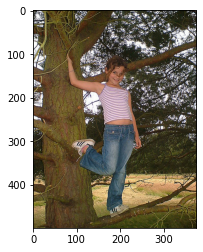

Caption: woman in pink shirt and jeans is standing on the grass
_____________________________________
/content/drive/MyDrive/싸피/인공지능음성/image_caption/Flicker8k_Dataset/488408004_a1e26d4886.jpg


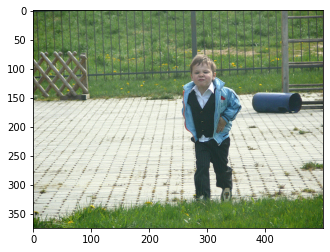

Caption: man in black jacket and jeans is standing on sidewalk
_____________________________________


In [ ]:
# 데이터셋으로 이미지 캡셔닝

for z in range(2): # set higher to see more examples
  pic = list(encoding_test.keys())[z]
  image = encoding_test[pic].reshape((1,OUTPUT_DIM))
  # 이미지 데이터셋에서 하나 가져옴
  print(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  x=plt.imread(os.path.join(root_captioning,'Flicker8k_Dataset', pic))
  plt.imshow(x)
  plt.show()
  print("Caption:",generateCaption(image))
  print("_____________________________________")

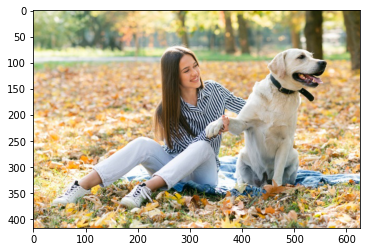

(1, 2048)
Caption: two little girls are sitting on the grass by the water
_____________________________________


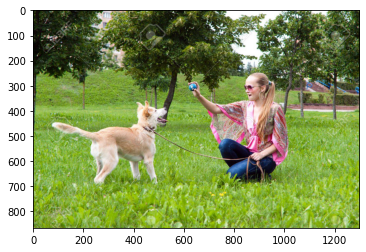

(1, 2048)
Caption: two dogs are playing together in the grass
_____________________________________


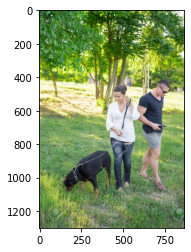

(1, 2048)
Caption: man and woman are sitting on the grass
_____________________________________


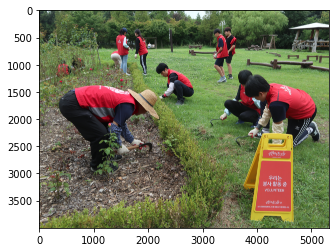

(1, 2048)
Caption: group of people are walking on grassy field
_____________________________________


In [47]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

%matplotlib inline

# 대충 이미지 주소
urls = ['https://image.freepik.com/free-photo/adult-woman-playing-with-her-dog-in-the-park_23-2148345896.jpg', 
        'https://previews.123rf.com/images/yatigra/yatigra1207/yatigra120700020/14504175-%EA%B7%B8%EB%85%80%EC%9D%98-%EA%B0%95%EC%95%84%EC%A7%80-%EA%B3%B5%EC%9B%90%EC%97%90%EC%84%9C-%EC%9E%AC%EC%83%9D%ED%95%98%EB%8A%94-%EB%A7%A4%EB%A0%A5%EC%A0%81%EC%9D%B8-%EC%97%AC%EC%9E%90.jpg',
        'https://previews.123rf.com/images/himchenko/himchenko1507/himchenko150700117/42936013-%EA%B0%9C%EB%8A%94-%EA%B3%B5%EC%9B%90%EC%9D%98-%EC%A3%BC%EC%9D%B8%EA%B3%BC-%ED%95%A8%EA%BB%98-%EB%85%B8%EB%8A%94-%EC%82%AC%EB%9E%8C%EC%9E%85%EB%8B%88%EB%8B%A4-.jpg',
        'https://www.greentrust.or.kr/wp-content/uploads/2020/07/%EC%B2%A8%EB%B6%801.-SGT%ED%99%88%ED%8E%98%EC%9D%B4%EC%A7%80-%EB%B3%80%EA%B2%BD%EC%82%AC%EC%A7%84.jpg',
        
        ]

for url in urls:
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  img.load()

  plt.imshow(img)
  plt.show()
  
  response = requests.get(url)

  img = encodeImage(img).reshape((1,OUTPUT_DIM))
  print(img.shape)
  print("Caption:",generateCaption(img))
  print("_____________________________________")

/content/drive/MyDrive/싸피/인공지능음성/image_caption/data/park.png


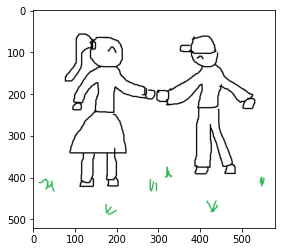

Caption: man in black jacket and jeans is standing on sidewalk
_____________________________________


In [48]:
# 내가 그린 샘플로 돌려보기  
pic = 'park.png'
print(os.path.join(root_captioning,'data', pic))
x=plt.imread(os.path.join(root_captioning,'data', pic))
plt.imshow(x)
plt.show()
print("Caption:",generateCaption(image))
print("_____________________________________")